<a href="https://colab.research.google.com/github/FaridRasulov/NeuralODE/blob/master/ThesisImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture 
!pip install torchdiffeq 
!pip install pytorch_utils 
!pip install tqdm 
!pip install adversarial-robustness-toolbox 
!pip install kornia
!pip install foolbox

In [ ]:
import os
import argparse
import logging
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
import os
import os.path
from os import path

import torch.nn.functional as F
import torch.optim as optim
from art.attacks.evasion import CarliniL2Method, ZooAttack, BoundaryAttack
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox as MIBB
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist 

import random
import itertools
from sklearn.model_selection import train_test_split  
from torchdiffeq import odeint_adjoint as odeint
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import roc_curve, auc

In [ ]:
%%capture
directory = r'./GTSRB'
if path.exists(directory)!=True:
  !wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
  !wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
  !unzip GTSRB_Final_Training_Images.zip
  !unzip GTSRB_Final_Test_Images.zip
#!find ./GTSRB/ -type f | sed -e 's/.*\.//' | sort | uniq -c | sort -n | grep -Ei '(ppm)$'

In [ ]:
directory = r'./GTSRB'
def get_dataset(directory, dataset, numclass, imSize=None,norm=True):
  x = list()
  y = list()
  directory = directory + dataset
  for subdir, dirs, files in os.walk(directory): 
    if subdir == directory: 
        continue 
    for filename in files: 
          filepath = subdir + os.sep + filename 
          if filename.endswith(".ppm"): 
              img = Image.open(filepath)
              if imSize:
                img = img.resize((imSize,imSize),Image.ANTIALIAS) 
              #img = img.convert('L') 
              img = np.asarray(img)
              if norm:
                img = (img - np.min(img))/(np.max(img) - np.min(img)) 
              x.append(img) 
          elif filename.endswith(".csv"): 
              data = np.genfromtxt(filepath, dtype=None, delimiter=',', skip_header=1, encoding='utf8') 
              y_tmp = np.zeros(shape=(data.shape[0],numclass), dtype=np.float32) 
              classID = int(data[0].split(';')[-1]) 
              y_tmp[:,classID] = 1 
              y.append(y_tmp) 
          else: 
            continue 

  x = np.asarray(x)
  #x = np.expand_dims(x, axis=3) 
  y = np.concatenate(y, axis=0, out=None)
  print(x.shape, y.shape) 
  y_lst=list() 
  for i in y: 
    y_lst.append(np.where(i == 1.)[0][0]) 
  y_set = set(y_lst) 
  print(len(y_set)) 
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42) 
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), np.min(x), np.max(x) 

In [ ]:
# Step 1: Load the MNIST dataset
#(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
(x_train, y_train),(x_val, y_val),(x_test, y_test),min_pixel_value,max_pixel_value = get_dataset(directory,'/Final_Training',43,28)
print('Step 1: Load the MNIST dataset')
# Step 1a: Swap axes to PyTorch's NCHW format
x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_val = np.swapaxes(x_val, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)
print("Step 1a: Swap axes to PyTorch's NCHW format")

(39209, 28, 28, 3) (39209, 43)
43
Step 1: Load the MNIST dataset
Step 1a: Swap axes to PyTorch's NCHW format


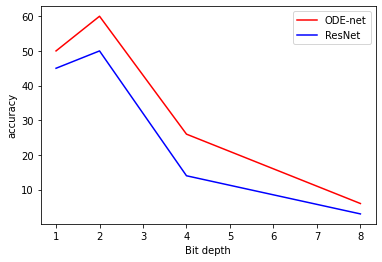

In [ ]:
import matplotlib.pyplot as plt
plt.plot([1,2,4,8],[50, 60, 26, 6],color='r',label='ODE-net')
plt.plot([1,2,4,8],[45, 50, 14, 3],color='b', label='ResNet')
plt.legend(loc="upper right")
plt.xlabel('Bit depth')
plt.ylabel('accuracy')
plt.savefig('bitdepth.png')
plt.show()

In [ ]:
def test_class_probabilities(model, test_loader, n_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            labels = labels.to(device)
            inputs = images.to(device)
            outputs = model(inputs)
            values, predicted = torch.max(outputs, 1)
            actuals.extend([i.item() for i in predicted])
            probabilities.extend([i.item() for i in torch.nn.functional.softmax(values, dim=0)])
    return actuals, probabilities       


def plot_roc( actuals,  probabilities, n_classes,model):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actuals, probabilities, pos_label=i)
        #if i == 19:print(fpr[i], '\n', tpr[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10,8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right",ncol=4,bbox_to_anchor=(1.013, 1))
    plt.tight_layout()
    plt.savefig(model+'ROCclass.png')
    plt.show()

In [ ]:
actuals_res, probabilities_res = test_class_probabilities(classifier_res.model, testloader,43)

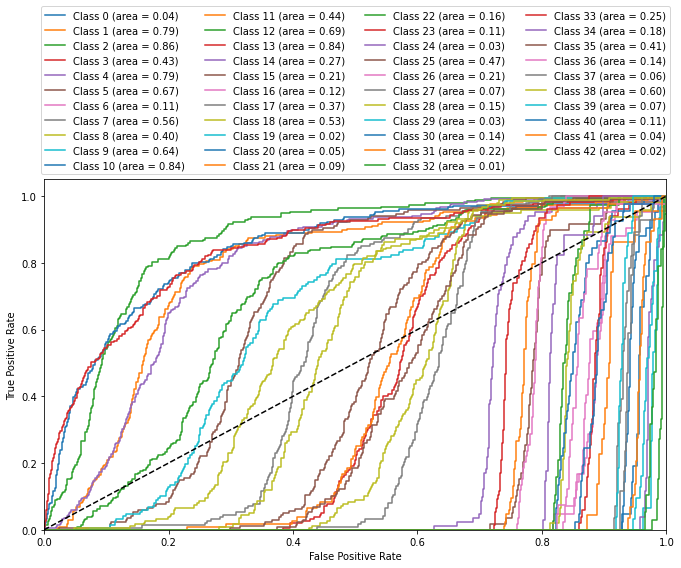

In [ ]:
plot_roc(actuals_res, probabilities_res,43,'res')

In [ ]:
actuals_ode, probabilities_ode = test_class_probabilities(classifier_ode.model, testloader,43)

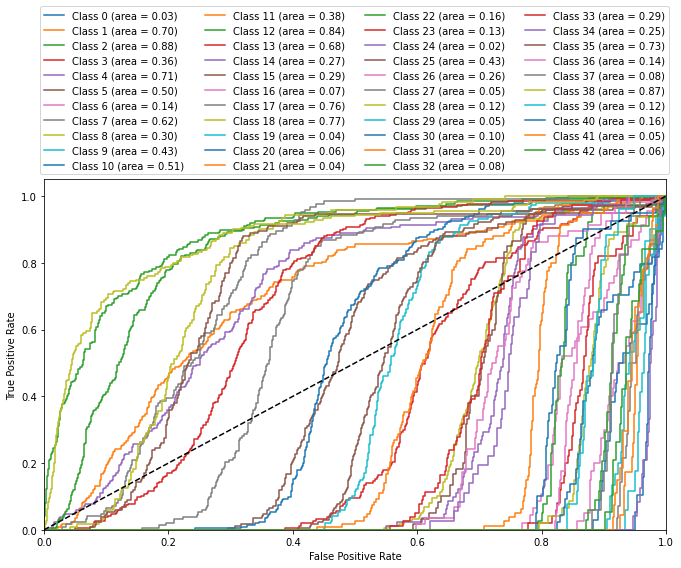

In [ ]:
plot_roc(actuals_ode, probabilities_ode,43,'ode')

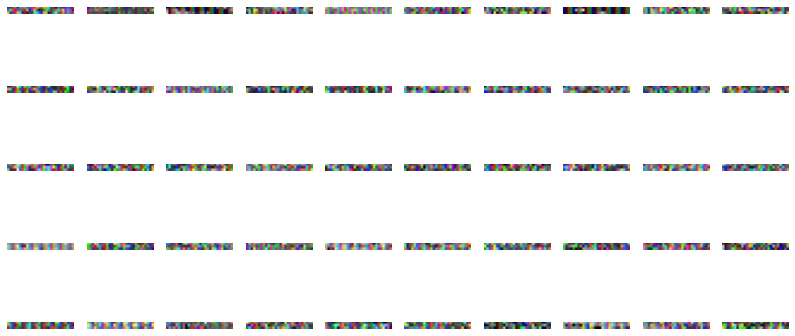

In [ ]:
#x_train, y_train, x_test, y_test, min_, max_ = get_dataset(directory,'/Final_Training',43,50,False)

width = 10
height = 5
fig,ax = plt.subplots(height,width,figsize=(14,7))

for cn, img in enumerate(x_test):
    if cn>=width*height:break
    image=Image.fromarray(img, mode="RGB")
    ax[cn%height][cn//height].imshow(image)
    ax[cn%height][cn//height].axis('off')
fig.show()
fig.savefig('imageset.png')

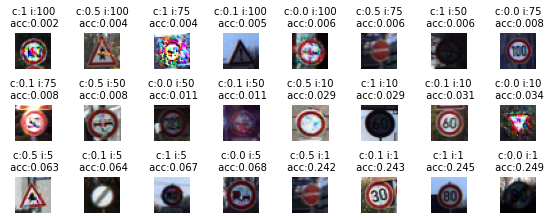

In [ ]:
import random
import itertools
import matplotlib.pyplot as plt
from PIL import Image

width = 8
height = 3

fig,ax = plt.subplots(height,width,figsize=(10,10),squeeze=False )      

h = 0       
for en,k in enumerate(sorted_dic.keys()):       
  ind = random.sample(range(sorted_dic[k][0].shape[0]), 1)      
  w = en%8
  if en in range(8,30,8):
    h+=1
  img = np.swapaxes(sorted_dic[k][0][ind], 1, 3).astype(np.float32)
  ax[h][w].imshow(img.reshape(28,28,3))
  ax[h][w].set_title('c:'+str(k[0])+' i:'+str(k[1])+'\n acc:'+str(sorted_dic[k][1]),fontsize=10)
  ax[h][w].axis('off')      

fig.tight_layout(h_pad=0, w_pad=0.1, rect=None)  
fig.subplots_adjust(left=0, bottom=0, right=0.75, top=0.25, wspace=0.25, hspace=1)    
fig.show()      
fig.savefig('resCWhyper.png')       

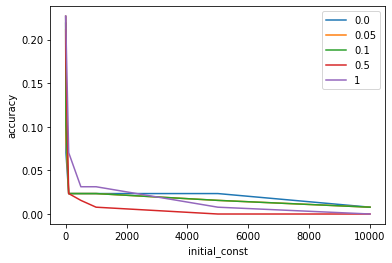

In [ ]:
import matplotlib.pyplot as plt
for c in params['confidence']:
  plt.plot(params['initial_const'],acc[c])
plt.legend(params['confidence'])
plt.xlabel('initial_const')
plt.ylabel('accuracy')
plt.show()

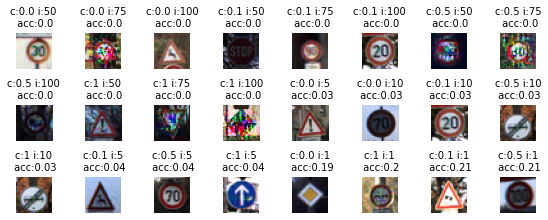

In [ ]:
import random
import itertools
import matplotlib.pyplot as plt
from PIL import Image

width = 8
height = 3

fig,ax = plt.subplots(height,width,figsize=(10,10),squeeze=False )      

h = 0       
for en,k in enumerate(sorted_dic.keys()):       
  ind = random.sample(range(sorted_dic[k][0].shape[0]), 1)      
  w = en%8
  if en in range(8,30,8):
    h+=1
  img = np.swapaxes(sorted_dic[k][0][ind], 1, 3).astype(np.float32)
  ax[h][w].imshow(img.reshape(28,28,3))
  ax[h][w].set_title('c:'+str(k[0])+' i:'+str(k[1])+'\n acc:'+str(sorted_dic[k][1]),fontsize=10)
  ax[h][w].axis('off')      

fig.tight_layout(h_pad=0, w_pad=0.1, rect=None)  
fig.subplots_adjust(left=0, bottom=0, right=0.75, top=0.25, wspace=0.25, hspace=1)    
fig.show()      
fig.savefig('odeCWhyper.png')       

In [ ]:
indexes = [np.where(np.argmax(y_test, axis=1)==item)[0][0] for item in range(43)]

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
img = np.swapaxes(images[[item]], 1, 3).astype(np.float32)

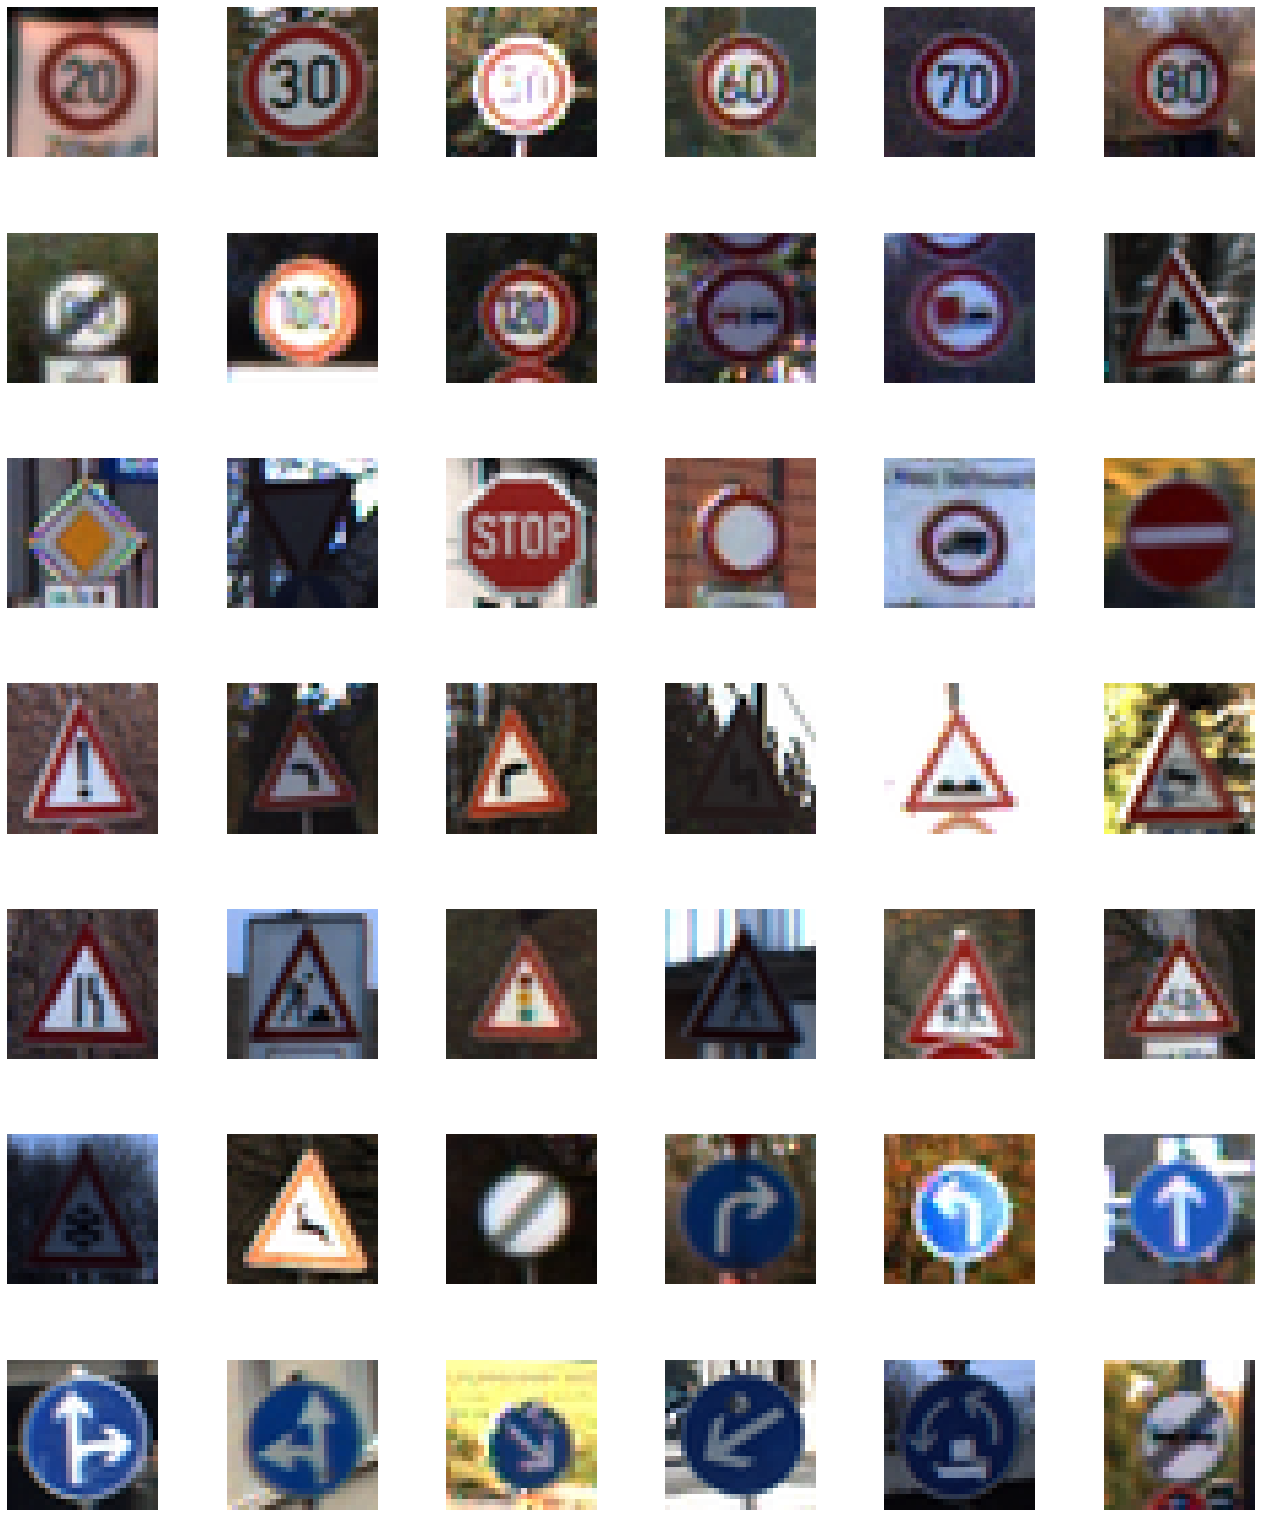

In [ ]:
import random
import itertools
import matplotlib.pyplot as plt
from PIL import Image

width = 6
height = 8
images = x_test
indexes = [np.where(np.argmax(y_test, axis=1)==item)[0][0] for item in range(43)]
fig,ax = plt.subplots(height,width,figsize=(width*15,height*15),squeeze=False )      

h = 0
for en, item in enumerate(indexes):
  w = en%width
  if en in range(width,width*height,width):
    h+=1
  img = np.swapaxes(images[[item]], 1, 3).astype(np.float32)
  ax[h][w].imshow(img.reshape(28,28,3))
  #ax[h][w].set_title('class:'+str(np.argmax(y_test[item])),fontsize=10)
  ax[h][w].axis('off')

fig.delaxes(ax[7][5])
fig.delaxes(ax[7][4])
fig.delaxes(ax[7][3])
fig.delaxes(ax[7][2])
fig.delaxes(ax[7][1])
fig.delaxes(ax[7][0])
fig.tight_layout(h_pad=0, w_pad=0.1, rect=None)  
fig.subplots_adjust(left=0, bottom=0, right=0.2, top=0.2, wspace=0.1, hspace=0.5)    
fig.savefig('classes.png')
fig.show()

In [ ]:
targets = ((0,1),(1,0),(2,3),(3,2),(4,5),(5,4),(6,32),(7,8),(8,7),(9,10),(10,9),
            (11,30),(12,13),(13,15),(14,17),(15,13),(16,10),(17,14),(18,26),(19,20),(20,19),
              (21,31),(22,23),(23,22),(24,27),(25,28),(26,18),(27,24),(28,25),(29,31),(30,11),
                (31,21),(32,6),(33,34),(34,33),(35,36),(36,35),(37,35),(38,39),(39,38),(40,39),
                  (41,42),(42,41))

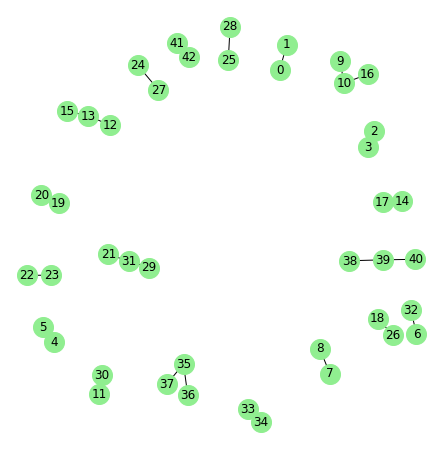

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

G=nx.Graph()
for i in range(43):
    G.add_node(i)

for i in targets:
  G.add_edge(i[0],i[1], size=1)

pos=nx.spring_layout(G, scale=30, k=1.7/np.sqrt(G.order()))

fig=plt.figure(figsize=(8,8))
ax=plt.subplot()
ax.set_aspect('equal')
nx.draw(G, pos=pos, with_labels=True, node_color='lightgreen', node_size=400)
#plt.savefig('origtarget.png')

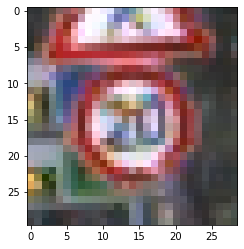

In [ ]:
# Python program to read 
# image using matplotlib 

# importing matplotlib modules 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

# Read Images 
img = mpimg.imread('./GTSRB/Final_Training/Images/00000/00000_00000.ppm') 
img_orig = img
img_norm = (img - np.min(img))/(np.max(img) - np.min(img)) 
img_int = (255*(img_norm - np.min(img_norm))/np.ptp(img_norm)).astype(int) 
#Output Images 
#plt.imshow(img_orig)
#plt.imshow(img_norm)
plt.imshow(img_int)

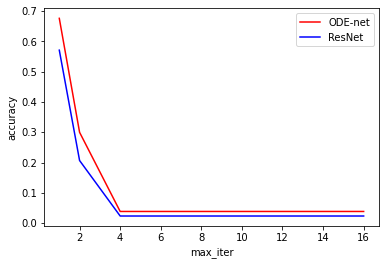

In [ ]:
import matplotlib.pyplot as plt
plt.plot(max_iter,acc['ode'],'r', label="ODE-net")
plt.plot(max_iter,acc['res'],'b', label="ResNet")
plt.xlabel('max_iter')
plt.ylabel('accuracy')
plt.legend(loc="upper right")
plt.savefig('maxIterPlot.png')
plt.show()

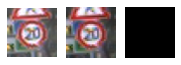

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from PIL import Image

width = 3
height = 1
fig,ax = plt.subplots(height,width,figsize=(3,1),squeeze=False )

#img_orig =Image.fromarray(img_orig, mode="RGB")
ax[0][0].imshow(img_orig)
ax[0][0].axis('off')
#img_norm=Image.fromarray(img_norm, mode="RGB")
ax[0][1].imshow(img_norm)
ax[0][1].axis('off')
#img_int=Image.fromarray(img_int, mode="RGB")
ax[0][2].imshow(img_int)
ax[0][2].axis('off')
fig.show()